# 30 - Classifying All-NBA Players (Reviewing Trees for Feature Selection)
I'm pretty happy with our models and predictions. I can say that while I was making those 10 posts about those 10 different models, I really started to question my objectives, and life in general and why I was even doing what I was doing. I was so far removed from any tangible predictions and was just caught up in AUC, and sensitivity / specificity metrics. Never once did I actually try to predict it on a test data set until the last post. Again, _**super happy**_ to see that the results were on the right track.

Throughout that whole journey, though, I had one thing (among others) in the back of my mind: Feature selection. Even though the model is performing relatively well, I couldn't help but think that we were using only two features. At the end of the day, I basically hand-picked these two because I knew they were all-encapsuling metrics. Since WS and VORP are based upon your overall "contribution" to the team, they take into account PTS, REB, AST... etc intrinsically. This is nice and all, but we are really just guessing that WS and VORP have the most to do with all-NBA status... We didn't even try to quantify any other metric. Since we're trying to find _**the best model**_, I can't tell you for sure that PTS isn't an important factor because I never really tried to find out! I just went with my intuition. Even now, I'm pretty happy with the model in general, but I can't say that it can't be better because I started with 2 features and stuck with my guns the whole time.

If we extend our scope of finding the best model, I think any activities with some rhyme or reason will be able to be modeled in the future state of our world. Even if we take a really simple act like whether or not someone will pass the ball, you could probably theoretically generate a model with super detailed features like where their eyes are looking, the angle of their elbows at the time, the way they are holding the ball, the placement of their defender, the placement of the defender on their teammate they are passing to... etc we could go on forever right? If you could get down to like a millimeter measurement of every aspect of everything on the floor ever, you could probably predict what anyone will do at any given time. So back to my WS and VORP example, I _**know**_ the model can be better for sure, but it's just a matter of finding which features matter the most, and in this data set specifically, we don't quite have too in-depth measurements. Having said that, though, bball-ref still has one of the richest datasets out there, and there is still a lot to parse through for someone like me who is just getting acquainted with many of these metrics.

At one point in the beginning, I found myself thinking "man, there are a ton of metrics here... I'd better do my research to get some context on what each of these mean and whether they intuitively sway an all-NBA vote or not". That's why I took a deeper dive into WS and VORP right? Because I wanted to understand what the hell was actually going on there. Going through the trees chapter in ESL and using the tree-based methods (single decision trees, random forests, gradient boosted trees), it's clear that, if I have a regression or classification objective, a tree-based method would actually be able to shoulder some of this feature selection responsibility for me.

Feature selection is an interesting thing. Many models can actually do it, and even logistic regression intrinsically is performing feature selection because we're assigning a coefficient that's literally saying "hey, this is the quantitative amoung in which this feature affects the log-odds of the output being this class". We saw the effects of multicollinearity in post \#22 about logistic regression, so have to go through an extra step of calculating the VIF if we want our model to work properly (which goes hand in hand with feature selection). Trees on the other hand, don't have this problem, and in fact if we look back to post \#23, we list a bunch of advantages that trees have over pretty much every other model:
- Fast to construct
- Interpretable models (if trees are relatively small)
- Can naturally incorporate numeric and categorical featuers
- Immune to outliers
- _**Perform internal feature selection**_

And from what we saw before, it seemed pretty cool that we could just output feature importances and that this was an _**intrinsic characteristic**_ of ensemble learning, where we can be more confident that the results were constructed from a methodology that exerts low variance characteristics as well. It's also immune to outliers and multicollinearity because there's no statstical regression when choosing when to make the splits, it's simply calculating _**the best possible split, period.**_ If two features are highly correlated, one of them will still yield a better split, and that one will get chosen. Theoretically, we could just throw all the original features into something like a random forest, or even a single tree, and be able to get an idea of which features matter the most for our objective (in this case, classification).

I need to stop and review because, _**first of all**_, I am _**by no means**_ saying that we don't have to do our homework up front. I'm not saying throw all your variables into a random forest, get the top 2 or 3 features, and call it a day. I'm saying what a nice and useful exploratory tool you have at your dispoasal for preliminary exploratory analysis! If a tree continuously decides to split on WS and VORP, then clearly there is something there for us to explore. It won't answer the question "what makes a player all-NBA status?" but it will bring up the question "why do WS and VORP contribute so much to all-NBA production?" which will provide a stepping stone to the the ultimate objective.

Well, enough talking about it. Let's try it! I'll put in a few more features and throw them into a decision tree, random forest, and GBM to see what the feature importance plots give us.

In [1]:
# Load libraries & initial config
%load_ext rpy2.ipython

%R library(ggplot2)
%R library(gridExtra)
%R library(scales)
%R library(ggbiplot)

%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Retrieve team stats from S3
playerAggDfAllNbaAllStar = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfAllNbaAllStar20170606.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfAllNbaAllStar.dtypes))
print playerAggDfAllNbaAllStar.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

## Initial Feature Selection
I know we're performing feature selection here, but I just want to take a look at the data really quick and ensure there are no features that make no sense in the data set. For example, from the features above, I'd obviously want to remove _**season_start_year**_ as the season has no correlation whatsoever with whether a player is picked. _**perGameStats_Pos**_ will probably be removed as well because we understand the correlation here (every year has G / G / F / F / C) and it's not something we're looking for to explain all-NBA status.

In [85]:
# Select braoder set of features manually
selectedCols = [
    'perGameStats_Age',
    'perGameStats_G',
    'perGameStats_GS',
    'perGameStats_MP',
    'per100Stats_FG',
    'per100Stats_FGA',
    'per100Stats_FGPerc',
    'per100Stats_3P',
    'per100Stats_3PA',
    'per100Stats_3PPerc',
    'per100Stats_2P',
    'per100Stats_2PA',
    'per100Stats_2PPerc',
    'per100Stats_FT',
    'per100Stats_FTA',
    'per100Stats_FTPerc',
    'per100Stats_ORB',
    'per100Stats_DRB',
    'per100Stats_TRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV',
    'per100Stats_PF',
    'per100Stats_PTS',
    'per100Stats_ORtg',
    'per100Stats_DRtg',
    'advancedStats_PER',
    'advancedStats_TSPerc',
    'advancedStats_3PAr',
    'advancedStats_FTr',
    'advancedStats_ORBPerc',
    'advancedStats_DRBPerc',
    'advancedStats_TRBPerc',
    'advancedStats_ASTPerc',
    'advancedStats_STLPerc',
    'advancedStats_BLKPerc',
    'advancedStats_TOVPerc',
    'advancedStats_USGPerc',
    'advancedStats_OWS',
    'advancedStats_DWS',
    'advancedStats_WS',
    'advancedStats_WS48',
    'advancedStats_OBPM',
    'advancedStats_DBPM',
    'advancedStats_BPM',
    'advancedStats_VORP',
    'accolades_all_nba'
]

playerAggDfAllNbaAllStarInitFeatures = playerAggDfAllNbaAllStar[selectedCols]

We should also check out if there are any missing values here

In [28]:
# Check for na values in each column
for column in playerAggDfAllNbaAllStarInitFeatures.columns:
    print 'there are {} na values in the column {}'.format(
        len(playerAggDfAllNbaAllStarInitFeatures[pd.isnull(playerAggDfAllNbaAllStarInitFeatures[column])]),
        column
    )

there are 0 na values in the column perGameStats_Age
there are 0 na values in the column perGameStats_G
there are 540 na values in the column perGameStats_GS
there are 0 na values in the column perGameStats_MP
there are 0 na values in the column per100Stats_FG
there are 0 na values in the column per100Stats_FGA
there are 0 na values in the column per100Stats_FGPerc
there are 0 na values in the column per100Stats_3P
there are 0 na values in the column per100Stats_3PA
there are 1344 na values in the column per100Stats_3PPerc
there are 0 na values in the column per100Stats_2P
there are 0 na values in the column per100Stats_2PA
there are 0 na values in the column per100Stats_2PPerc
there are 0 na values in the column per100Stats_FT
there are 0 na values in the column per100Stats_FTA
there are 3 na values in the column per100Stats_FTPerc
there are 0 na values in the column per100Stats_ORB
there are 0 na values in the column per100Stats_DRB
there are 0 na values in the column per100Stats_TRB

Alright, let's drop games started and 3P% because I'm just looking for a lazy way to get out of this and we already have so many features anyways.

In [29]:
# Drop GS & 3P%
playerAggDfAllNbaAllStarInitFeatures = playerAggDfAllNbaAllStarInitFeatures.drop(['perGameStats_GS', 'per100Stats_3PPerc'], 1)

In [30]:
# Drop any rows with remaining NA's (FT% has 3 rows)
print playerAggDfAllNbaAllStarInitFeatures.shape
playerAggDfAllNbaAllStarInitFeatures.dropna(inplace = True)
print playerAggDfAllNbaAllStarInitFeatures.shape

(13223, 46)
(13220, 46)


# Decision Tree
Okay, lol, who knows how this will work out, but let's give it a go with the decision tree. Here, I'll literally throw every feature above into the model and measure on _**accolades_all_nba**_.

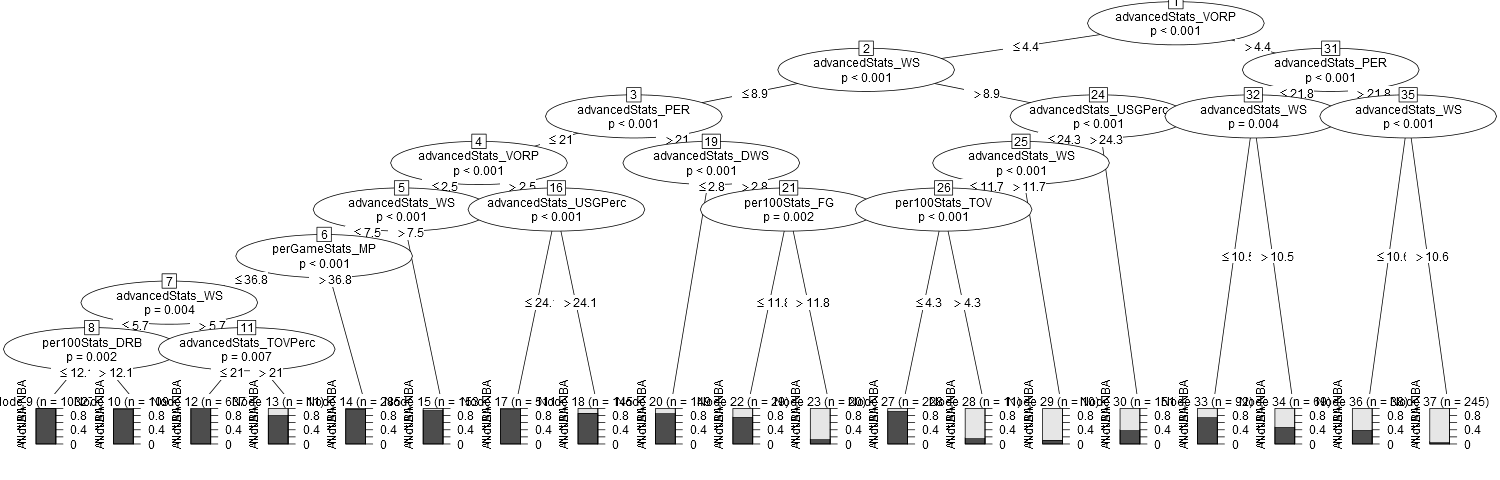

In [31]:
%%R -i playerAggDfAllNbaAllStarInitFeatures -w 1500 -u px
library('party')

# Build tree using the ctree tool within the party package
ctreeModel = ctree(
    accolades_all_nba ~ ., 
    data = playerAggDfAllNbaAllStarInitFeatures
)

# Plot tree
plot(ctreeModel)

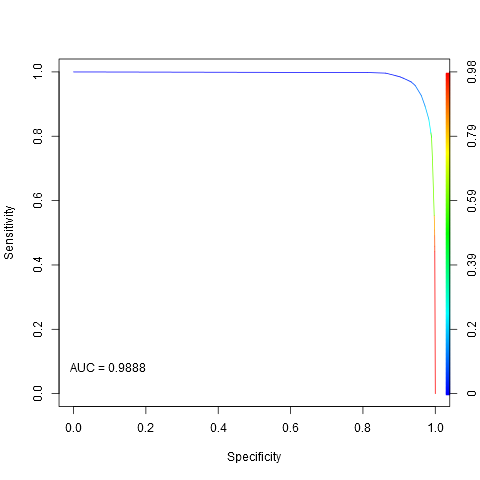

In [32]:
%%R
library(ROCR)

# Use the tree library to predict probabilities
cTreeModelPred = predict(ctreeModel, type = 'prob')

# Predict on ctree returns a list of vectors instead of a data frame, we convert to dataframe here
cTreeModelPredDf = do.call(rbind, cTreeModelPred)

# Use the ROCR library to build the ROC curve
cTreePredObj = prediction(as.data.frame(cTreeModelPredDf[,1]), ifelse(playerAggDfAllNbaAllStarInitFeatures['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
cTreeRocEval = performance(cTreePredObj, 'sens', 'spec')
plot(cTreeRocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(cTreePredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

In [33]:
# Retrieve the iterative cut-off sensitivity analysis that logistic regression did behind the scenes
%R cutoffs = data.frame(cut = cTreeRocEval@alpha.values[[1]], sens = cTreeRocEval@x.values[[1]], spec = cTreeRocEval@y.values[[1]])

# Calculate the metrics sensitivity + specificity. This will help us gauge the accuracy of both classes simultaneously.
#   E.g. if we were guessing each class 100% correctly (there is a very distinct decision boundary), then we would have 1 + 1 = 2
%R cutoffs['sens_plus_spec'] = cutoffs['sens'] + cutoffs['spec']

# See the last few rows of this dataframe where the sensitivity + specificity are at its max
%R tail(cutoffs[order(cutoffs$sens_plus_spec),])

,cut,sens,spec,sens_plus_spec
12,0.137931,0.971739,0.893617,1.865356
17,0.018349,0.902700,0.984526,1.887226
13,0.114094,0.961348,0.926499,1.887847
16,0.021053,0.911123,0.980658,1.891781
14,0.070175,0.944659,0.957447,1.902106
15,0.039216,0.933087,0.969052,1.902139


Wow 97% / 93% with all the features... we're getting to a pretty good model here haha. This is miles ahead of my old model (i know, since when did 1% become miles eh...).

Some observations in no particular order:
- The first split is VORP on 4.4... this is _**the same first split**_ that we had when we ran the decision tree with just VORP & WS!
- Within the first few splits, we so frequently see VORP and WS... there are a few others sprinkled in there that are interesting like PER and USG%, but the tree is actually filtering out all the per100 stats. I'm not trying to say one thing or another, but it seems that advanced stats are doing a better job of mimicing what a media member is thinking when they vote for all-NBA teams
- The lower splits also get pretty interesting... to follow one branch
    - $VORP<4.4$
    - $WS>8.9$
    - $USG\%<24.3$
    - $WS<11.7$
    - This is already a pretty specific category, but somehow at the end of this the turnovers per 100 makes the ngiht and day difference as to whether someone is all-NBA or not...
- This is clearly less interpretable than the previous model... so it's up to the user... is the gain in accuracy worth the loss of interpretability? This could depend purely on the context of why someone wants to explore this information in the first place
    - If you're trying to build a deck for an executive and you only have 10 minutes to explain a model, you'd probably go with a simpler one
    - If you're trying to use this logic as part of an automated software solution that you're going to be selling to customers in a binding contract, you might want your predictions to be as accurate as possible regardless of interpretability
    
Let's move on to random forests.

In [65]:
# Unload package
%R detach(package:party, unload = T)

## Random Forest
Remember, for random forests, we can't quite see each tree as easily (and there will be hundreds or thousands of them so looking at 1 tree may not be too useful anyways). We do have the variable importance feature though as well as the out of bag errors to help us understand the data.

In [34]:
%%R
library(randomForest)

# Build random forest model
randomForestModel = randomForest(
    accolades_all_nba ~ ., 
    data = playerAggDfAllNbaAllStarInitFeatures,
    mtry = 1
)

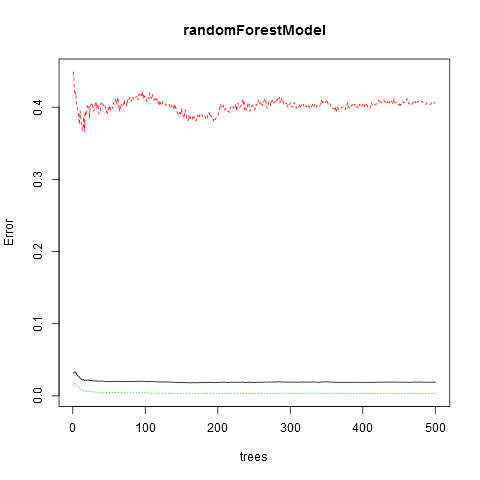

In [35]:
%%R
# Plot random forest model
plot(randomForestModel)

In [37]:
%%R

# Extract the column of ntree and OOB error rates
errRate = as.data.frame(randomForestModel['err.rate'])['err.rate.OOB']

# Find the number of trees which yield the minimum OOB error
minTree = min(which(errRate['err.rate.OOB'] == min(errRate['err.rate.OOB'])))

# Retrain tree with this number of trees
randomForestModelMinTrees = randomForest(
    accolades_all_nba ~ ., 
    data = playerAggDfAllNbaAllStarInitFeatures,
    ntree = minTree,
    mtry = 1
)

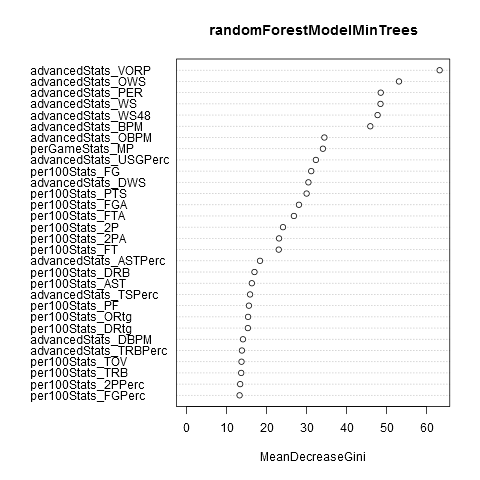

In [38]:
%%R
# Build variable importance plot
varImpPlot(randomForestModelMinTrees)

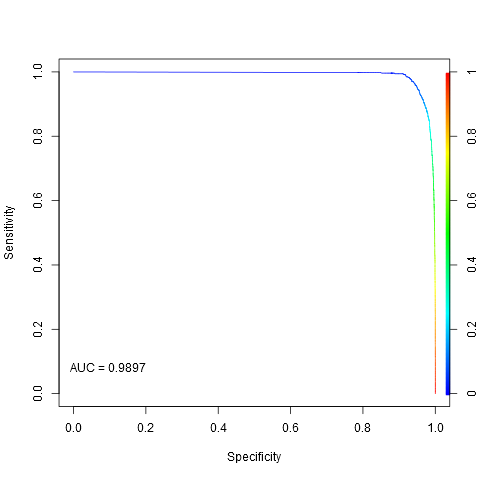

In [39]:
%%R -o randomForestModelMinTreesPred
library(ROCR)

# Use the tree library to predict probabilities
randomForestModelMinTreesPred = predict(randomForestModelMinTrees, type = 'prob')

# Use the ROCR library to build the ROC curve
randomForestPredObj = prediction(as.data.frame(randomForestModelMinTreesPred[,1]), ifelse(playerAggDfAllNbaAllStarInitFeatures['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
randomForestRocEval = performance(randomForestPredObj, 'sens', 'spec')
plot(randomForestRocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(randomForestPredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

In [40]:
# Retrieve the iterative cut-off sensitivity analysis that logistic regression did behind the scenes
%R cutoffs = data.frame(cut = randomForestRocEval@alpha.values[[1]], sens = randomForestRocEval@x.values[[1]], spec = randomForestRocEval@y.values[[1]])

# Calculate the metrics sensitivity + specificity. This will help us gauge the accuracy of both classes simultaneously.
#   E.g. if we were guessing each class 100% correctly (there is a very distinct decision boundary), then we would have 1 + 1 = 2
%R cutoffs['sens_plus_spec'] = cutoffs['sens'] + cutoffs['spec']

# See the last few rows of this dataframe where the sensitivity + specificity are at its max
%R tail(cutoffs[order(cutoffs$sens_plus_spec),])

,cut,sens,spec,sens_plus_spec
635,0.061538,0.933087,0.976789,1.909876
646,0.055556,0.927419,0.982592,1.910011
639,0.059701,0.931355,0.978723,1.910078
634,0.062500,0.933559,0.976789,1.910348
638,0.060000,0.931906,0.978723,1.910629
645,0.056338,0.928914,0.982592,1.911506


Okay, sorry, that's a lot of info to take in. While nothing is new and I literally just rehashed everything we did in post \#24, I probably was a bit trigger happy with all the charts and graphs.

This one does even better, getting achiving 98% / 93%! Of course, our variable importance plot is what we wanted to look at here, and it's quite surprising. Recall that when we had only WS and VORP, WS was the more important variable. Not by much, but still the more important one. Here VORP is the more importance feature and we go through OWS and PER before we even get to WS. PER is more important than WS?!?! Blasphemous.

Let's see what GBM gives us.

In [66]:
# Unload package
%R detach(package:randomForest, unload = T)

## Gradient Boosted Trees
Last one. Leggo. Let's find the optimal model parameters with cross validation first.

In [64]:
%%R -o gbModelMaxDepth1EvaluationLog

library(xgboost)

# Prepare x and y vars
x = data.matrix(playerAggDfAllNbaAllStarInitFeatures[, names(playerAggDfAllNbaAllStarInitFeatures) != 'accolades_all_nba'])
y = data.matrix(ifelse(playerAggDfAllNbaAllStarInitFeatures[,c('accolades_all_nba')] == 'All-NBA', 1, 0))

# Build gradient boosted tree model with 10-fold cross validation
gbModelMaxDepth1 = xgb.cv(
    data = x,
    label = y,
    nround = 1000,
    objective = 'binary:logistic',
    eval_metric = 'auc',
    nfold = 10,
    eta = 0.1,
    max_depth = 1
)

gbModelMaxDepth1EvaluationLog = data.frame(gbModelMaxDepth1['evaluation_log'])

<IPython.core.display.Javascript object>


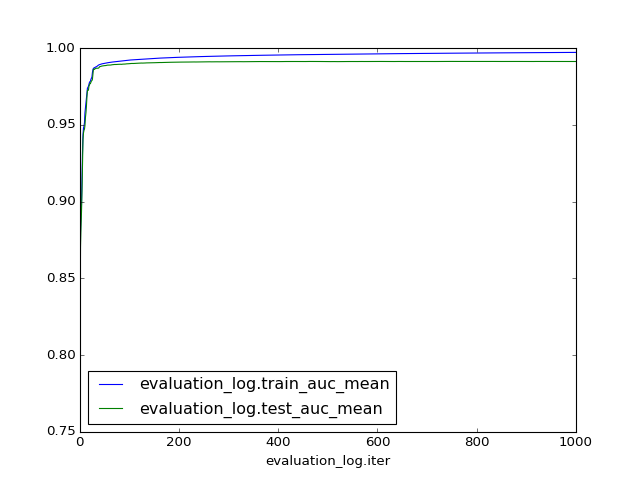

In [45]:
# Plot trainin and test errors
fig, ax = plt.subplots(1, 1)

gbModelMaxDepth1EvaluationLog.plot(
    kind = 'line',
    x = 'evaluation_log.iter',
    y = 'evaluation_log.train_auc_mean',
    ax = ax
)

gbModelMaxDepth1EvaluationLog.plot(
    kind = 'line',
    x = 'evaluation_log.iter',
    y = 'evaluation_log.test_auc_mean',
    ax = ax
)

Well, that's pretty nuts. It seems that anything over 350 will just continue to stay the same, so let's just go with 350 trees as our benchmark as to not overfit

In [46]:
%%R -o gbModelFinal

# Build gradient boosted tree model
gbModelFinal = xgboost(
    data = x,
    label = y,
    nround = 350,
    objective = 'binary:logistic',
    eval_metric = 'auc',
    eta = 0.1,
    max_depth = 1
)

gbModelFinalEvaluationLog = data.frame(gbModelFinal['evaluation_log'])

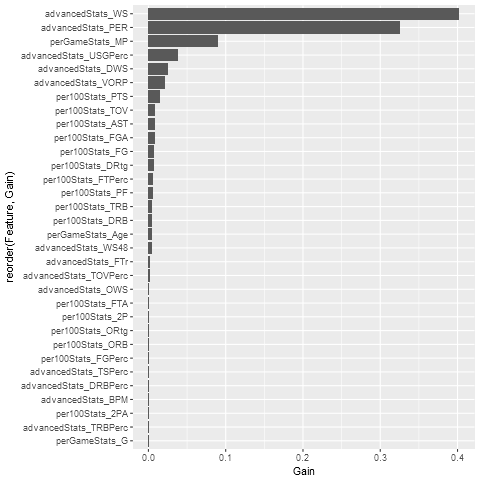

In [57]:
%%R

# Get the featuer importance data from xgboost
gbModelFeatureImportance = data.frame(xgb.importance(names(data.frame(x)), model = gbModelFinal))

# Plot feature importance graph
ggplot(
    data = gbModelFeatureImportance,
    aes(
        x = reorder(Feature, Gain),
        y = Gain
    )
) + geom_bar(stat = 'identity') + coord_flip()

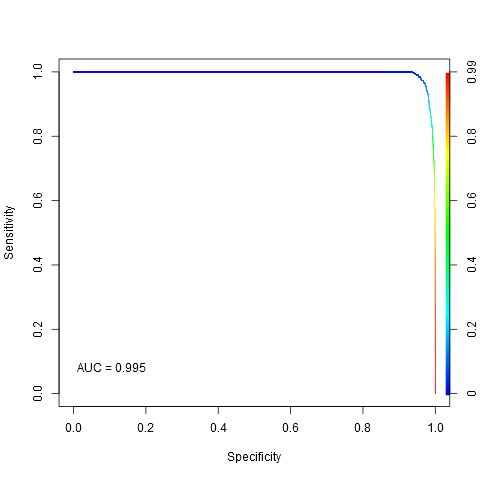

In [48]:
%%R
library(ROCR)

# Use the tree library to predict probabilities
gbModelFinalPred = predict(gbModelFinal, x)

# Use the ROCR library to build the ROC curve
gbModelFinalPredObj = prediction(gbModelFinalPred, ifelse(playerAggDfAllNbaAllStarInitFeatures['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
gbModelFinalRocEval = performance(gbModelFinalPredObj, 'sens', 'spec')
plot(gbModelFinalRocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(gbModelFinalPredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

In [49]:
# Retrieve the iterative cut-off sensitivity analysis that logistic regression did behind the scenes
%R cutoffs = data.frame(cut = gbModelFinalRocEval@alpha.values[[1]], sens = gbModelFinalRocEval@x.values[[1]], spec = gbModelFinalRocEval@y.values[[1]])

# Calculate the metrics sensitivity + specificity. This will help us gauge the accuracy of both classes simultaneously.
#   E.g. if we were guessing each class 100% correctly (there is a very distinct decision boundary), then we would have 1 + 1 = 2
%R cutoffs['sens_plus_spec'] = cutoffs['sens'] + cutoffs['spec']

# See the last few rows of this dataframe where the sensitivity + specificity are at its max
%R tail(cutoffs[order(cutoffs$sens_plus_spec),])

,cut,sens,spec,sens_plus_spec
1038,0.059767,0.958356,0.984526,1.942882
1114,0.049358,0.952610,0.990329,1.942938
1037,0.059813,0.958435,0.984526,1.942961
1113,0.049515,0.952688,0.990329,1.943017
1112,0.049518,0.952767,0.990329,1.943096
1111,0.049757,0.952846,0.990329,1.943175


Well, this is just stupid. I'm not quite sure how to take this, but ok. 99% / 95% with an AUC of 0.995 these are basically fictional numbers at this point... I know gradient boosted trees are good, but I'm honestly a bit skeptical that it's doing this well.

More importantly, let's look at the feature importance plot. Whaddya know... WS is back on top and VORP is way down there! This is telling me that, in the presence of one, the other is a bit redundant. We see PER creep up again and, while there is always the narrative that stats don't necessarily matter (which is true by the dominance of WS and VORP), it kind of does matter because PER is purely a stat based on other stats, period. Perhaps it provides an orthogonal / uncorrelated perspective to augment what VORP and WS are giving us... interesting stuff.

I'm actually curious to see how this model would do in our train / test split... Let's try it.

## Predicting 2017 All-NBA Using GBM + All Features

In [98]:
# Here we drop all the columns that had na's to save us some effort in matching up the dataframes later
headerCols = [
    'season_start_year',
    'perGameStats_Player',
    'perGameStats_Pos'
]

selectedColsPredict = [
    'perGameStats_Age',
    'perGameStats_G',
    'perGameStats_MP',
    'per100Stats_FG',
    'per100Stats_FGA',
    'per100Stats_FGPerc',
    'per100Stats_3P',
    'per100Stats_3PA',
    'per100Stats_2P',
    'per100Stats_2PA',
    'per100Stats_2PPerc',
    'per100Stats_FT',
    'per100Stats_FTA',
    'per100Stats_ORB',
    'per100Stats_DRB',
    'per100Stats_TRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV',
    'per100Stats_PF',
    'per100Stats_PTS',
    'per100Stats_ORtg',
    'per100Stats_DRtg',
    'advancedStats_PER',
    'advancedStats_TSPerc',
    'advancedStats_3PAr',
    'advancedStats_FTr',
    'advancedStats_ORBPerc',
    'advancedStats_DRBPerc',
    'advancedStats_TRBPerc',
    'advancedStats_ASTPerc',
    'advancedStats_STLPerc',
    'advancedStats_BLKPerc',
    'advancedStats_TOVPerc',
    'advancedStats_USGPerc',
    'advancedStats_OWS',
    'advancedStats_DWS',
    'advancedStats_WS',
    'advancedStats_WS48',
    'advancedStats_OBPM',
    'advancedStats_DBPM',
    'advancedStats_BPM',
    'advancedStats_VORP',
    'accolades_all_nba'
]

# Our training set only contains players prior to the 2016-2017 season
playerAggDfAllNbaAllStarTrainAllCols = playerAggDfAllNbaAllStar[playerAggDfAllNbaAllStar['season_start_year'] != 2016]
playerAggDfAllNbaAllStarTrain = playerAggDfAllNbaAllStarTrainAllCols[selectedColsPredict]

# Our test set only contains players from the 2016-2017 season
playerAggDfAllNbaAllStarTestAllCols = playerAggDfAllNbaAllStar[playerAggDfAllNbaAllStar['season_start_year'] == 2016]
playerAggDfAllNbaAllStarTest = playerAggDfAllNbaAllStarTestAllCols[selectedColsPredict]

# Take a dataframe of just the header columns which will not take part in the prediction, but will help us identify the players later on
playerAggDfAllNbaAllStarTestHeaderCols = playerAggDfAllNbaAllStarTestAllCols[headerCols]

# Pass to R
%R -i playerAggDfAllNbaAllStarTrain -i playerAggDfAllNbaAllStarTest -i playerAggDfAllNbaAllStarTestHeaderCols

In [211]:
%%R -o gbModel

# Prepare x and y vars
xTrain = data.matrix(playerAggDfAllNbaAllStarTrain[, names(playerAggDfAllNbaAllStarTrain) != 'accolades_all_nba'])
yTrain = data.matrix(ifelse(playerAggDfAllNbaAllStarTrain[,c('accolades_all_nba')] == 'All-NBA', 1, 0))

xTest = data.matrix(playerAggDfAllNbaAllStarTest[, names(playerAggDfAllNbaAllStarTest) != 'accolades_all_nba'])

# Model
gbModel = xgboost(
    data = xTrain,
    label = yTrain,
    nround = 350,
    objective = 'binary:logistic',
    eval_metric = 'auc',
    eta = 0.1,
    max_depth = 1
)

# Predict
gbModelProb = predict(gbModel, xTest)
gbModelPred = ifelse(gbModelProb >= 0.049757, 'All-NBA', 'Not All-NBA')

In [96]:
# Check results
%R print(head(gbModelPred))

array(['Not All-NBA', 'Not All-NBA', 'Not All-NBA', 'Not All-NBA',
       'Not All-NBA', 'Not All-NBA'], 
      dtype='|S11')

In [100]:
%%R -o playerAggDfAllNbaAllStarTestWithPred

# Take only the columns we want to see
playerAggDfAllNbaAllStarTestWithPred = cbind(playerAggDfAllNbaAllStarTestHeaderCols, playerAggDfAllNbaAllStarTest[,c('accolades_all_nba')])

# Let's append the results to the test data frame and change the 'All-NBA' values to a 1, so we can add how many classifiers voted for a player to be all-NBA ('Not All-NBA' becomes 0)
playerAggDfAllNbaAllStarTestWithPred['gbm_pred'] = gbModelPred

In [103]:
# Sort the table based on our prediction, so we can see who got all-NBA votes
playerAggDfAllNbaAllStarTestWithPred.sort_values('gbm_pred', ascending = True, inplace = True)

# Check results
playerAggDfAllNbaAllStarTestWithPred.head(50)

,season_start_year,perGameStats_Player,perGameStats_Pos,"playerAggDfAllNbaAllStarTest[, c(""accolades_all_nba"")]",gbm_pred
12907,2016,Kevin Durant,SF,All-NBA,All-NBA
12996,2016,Kyrie Irving,PG,Not All-NBA,All-NBA
13197,2016,Russell Westbrook,PG,All-NBA,All-NBA
12895,2016,DeMar DeRozan,SG,All-NBA,All-NBA
12934,2016,Paul George,SF,Not All-NBA,All-NBA
13043,2016,Damian Lillard,PG,Not All-NBA,All-NBA
13192,2016,John Wall,PG,All-NBA,All-NBA
12939,2016,Rudy Gobert,C,All-NBA,All-NBA
12877,2016,Mike Conley,PG,Not All-NBA,All-NBA
12830,2016,Bradley Beal,SG,Not All-NBA,All-NBA


Okay, the model actually selects 35 nba all-stars here... Not quite what we want as it's obviously 100% in its predictions but it's misclassifying a good 20 guys. Maybe we can tweak the threshold of what we consider all-NBA in the GBM's probability results to see if we can bring the number of players classified down to 15 or so.

In [194]:
%%R -o thresholds -o allNbaCount

# Create counter to increment our list storing results
allNbaCount = NULL

# Create list of probability thresholds to test
thresholds = seq(0.05, 0.95, 0.05)

# Iterate through all the values of thresholds to find the number of all-NBA players classified at each step
for (threshold in thresholds) {
    # Try threshold
    gbModelPredTable = table(ifelse(gbModelProb >= threshold, 'All-NBA', 'Not All-NBA'))
    
    # Grab resulting number of all-NBA classifications
    allNbaCount = c(allNbaCount, as.numeric(gbModelPredTable[names(gbModelPredTable) == 'All-NBA']))
}

<IPython.core.display.Javascript object>


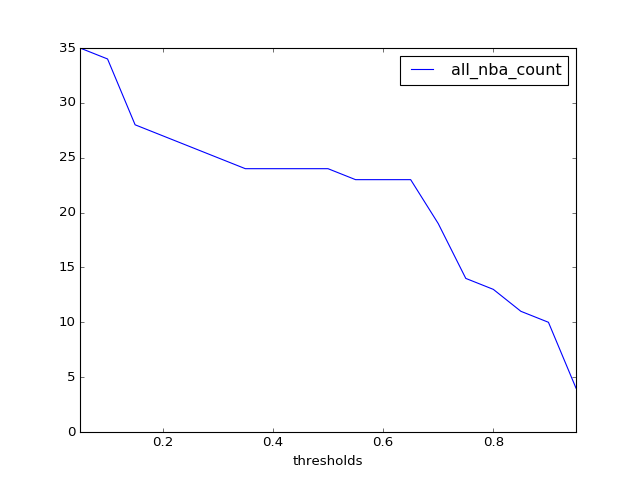

In [195]:
# Plot
pd.DataFrame({
    'thresholds': thresholds,
    'all_nba_count': allNbaCount
}).plot(
    x = 'thresholds',
    y = 'all_nba_count',
    kind = 'line'
)

At about a 0.73 threshold, we get 15 players, let's see who these guys are.

In [198]:
%%R -o playerAggDfAllNbaAllStarTestWithPred

# Generate predictions with new threshold
gbModelPred = ifelse(gbModelProb >= 0.73, 'All-NBA', 'Not All-NBA')

# Take only the columns we want to see
playerAggDfAllNbaAllStarTestWithPred = cbind(playerAggDfAllNbaAllStarTestHeaderCols, playerAggDfAllNbaAllStarTest[,c('advancedStats_WS', 'accolades_all_nba')])

# Let's append the results to the test data frame and change the 'All-NBA' values to a 1, so we can add how many classifiers voted for a player to be all-NBA ('Not All-NBA' becomes 0)
playerAggDfAllNbaAllStarTestWithPred['gbm_pred'] = gbModelPred

In [199]:
# Sort the table based on our prediction, so we can see who got all-NBA votes
playerAggDfAllNbaAllStarTestWithPred.sort_values('gbm_pred', ascending = True, inplace = True)

# Check results
playerAggDfAllNbaAllStarTestWithPred.head(30)

,season_start_year,perGameStats_Player,perGameStats_Pos,advancedStats_WS,accolades_all_nba,gbm_pred
13192,2016,John Wall,PG,8.8,All-NBA,All-NBA
12858,2016,Jimmy Butler,SF,13.8,All-NBA,All-NBA
12939,2016,Rudy Gobert,C,14.3,All-NBA,All-NBA
13037,2016,Kawhi Leonard,SF,13.6,All-NBA,All-NBA
13197,2016,Russell Westbrook,PG,13.1,All-NBA,All-NBA
12886,2016,Stephen Curry,PG,12.6,All-NBA,All-NBA
13200,2016,Hassan Whiteside,C,9.5,Not All-NBA,All-NBA
12888,2016,Anthony Davis,C,11.0,All-NBA,All-NBA
12878,2016,DeMarcus Cousins,C,7.6,Not All-NBA,All-NBA
13176,2016,Karl-Anthony Towns,C,12.7,Not All-NBA,All-NBA


We see here that we get 15 players, but they are not distributed as they should be in terms of the number of G / F / C's. I'm going to ease up on the threshold a bit to get like 20-25 players, then I will build the team.

In [209]:
%%R -o playerAggDfAllNbaAllStarTestWithPred

# Generate predictions with new threshold
gbModelPred = ifelse(gbModelProb >= 0.64, 'All-NBA', 'Not All-NBA')

# Take only the columns we want to see
playerAggDfAllNbaAllStarTestWithPred = cbind(playerAggDfAllNbaAllStarTestHeaderCols, playerAggDfAllNbaAllStarTest[,c('accolades_all_nba')])

# Let's append the results to the test data frame and change the 'All-NBA' values to a 1, so we can add how many classifiers voted for a player to be all-NBA ('Not All-NBA' becomes 0)
playerAggDfAllNbaAllStarTestWithPred['gbm_prob'] = gbModelProb
playerAggDfAllNbaAllStarTestWithPred['gbm_pred'] = gbModelPred

In [210]:
# Sort the table based on our prediction, so we can see who got all-NBA votes
playerAggDfAllNbaAllStarTestWithPred.sort_values(['gbm_pred', 'gbm_prob'], ascending = [True, False], inplace = True)

# Check results
playerAggDfAllNbaAllStarTestWithPred.head(30)

,season_start_year,perGameStats_Player,perGameStats_Pos,"playerAggDfAllNbaAllStarTest[, c(""accolades_all_nba"")]",gbm_prob,gbm_pred
13197,2016,Russell Westbrook,PG,All-NBA,0.994034,All-NBA
12954,2016,James Harden,PG,All-NBA,0.976767,All-NBA
12998,2016,LeBron James,SF,All-NBA,0.962744,All-NBA
12939,2016,Rudy Gobert,C,All-NBA,0.951678,All-NBA
13037,2016,Kawhi Leonard,SF,All-NBA,0.946407,All-NBA
12888,2016,Anthony Davis,C,All-NBA,0.932740,All-NBA
12858,2016,Jimmy Butler,SF,All-NBA,0.930105,All-NBA
12886,2016,Stephen Curry,PG,All-NBA,0.912962,All-NBA
12907,2016,Kevin Durant,SF,All-NBA,0.910041,All-NBA
12811,2016,Giannis Antetokounmpo,SF,All-NBA,0.905222,All-NBA


The team ends up being:

_**All-NBA First Team**_
- G: Russ
- G: Harden
- F: LBJ
- F: Kawhi
- C: Rudy Gobert

_**All-NBA Second Team**_
- G: Steph Curry
- G: IT
- F: Jimmy Butler
- F: KD
- C: AD

_**All-NBA Third Team**_
- G: John Wall
- G: DeMar DeRozan
- F: Giannis
- F: Gordon Hayward
- C: KAT

Wow the boosted tree itself with all the features got _**13 / 15 players**_!!! KAT was seen as a major snub, and we already went through some of the Draymond logic for the last post so that's actually quite impressive!! It almost got the first team completely correct as well except for Rudy (who was a TINY TINY margin away from first team anyways)

This one seemed to differentiate between John Wall and DeMar as well... Not quite sure how because we've muddled the model quite a bit with the additional features, but wow there you go, you can't argue with the predictive power there!

Let's check out the feature importance, I assume it's the same as before.

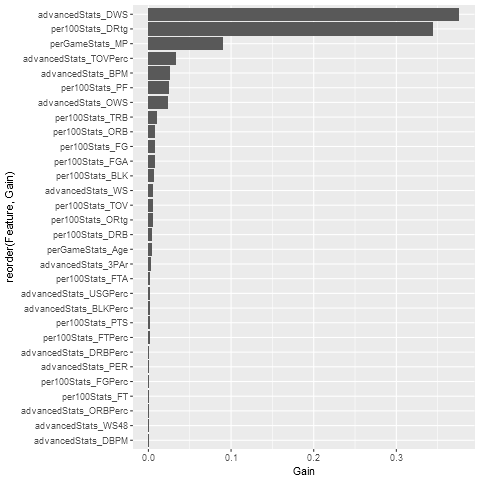

In [212]:
%%R

# Get the featuer importance data from xgboost
gbModelFeatureImportance = data.frame(xgb.importance(names(data.frame(x)), model = gbModel))

# Plot feature importance graph
ggplot(
    data = gbModelFeatureImportance,
    aes(
        x = reorder(Feature, Gain),
        y = Gain
    )
) + geom_bar(stat = 'identity') + coord_flip()

Well... that is _**quite**_ weird actually. This is completely different from last time. While WS is still important, it's DWS and DRtg that are playing the major roles this time. MP is still there, but VORP is actually nowhere to be seen... Not really sure what to make of this because I thought boosted trees would be relatively consistent every time.

Somehow the taking out of 2016-2017 data actually changed the model A LOT... That's REALLY weird as I didn't think 2016-2017 made that big of a difference. This new model clearly values defensive stats specifically a lot more than any others, although DWS is still a variation of WS on top. PER is basically nowhere to be seen now as it's probably being masked by another metric. This is where PCA would actually help us out a bit as clearly some of these are correlated.

I guess we see that, while trees are not _**immune**_ to multicollinearity in the sense that the model becomes unstable or loses predictive power, it is a bit vulnerable in terms of interpretability.

Lastly... How about Paul George tho...

In [218]:
# Paul Frickin George
playerAggDfAllNbaAllStarTestWithPred[playerAggDfAllNbaAllStarTestWithPred['perGameStats_Player'] == 'Paul George']

,season_start_year,perGameStats_Player,perGameStats_Pos,"playerAggDfAllNbaAllStarTest[, c(""accolades_all_nba"")]",gbm_prob,gbm_pred
12934,2016,Paul George,SF,Not All-NBA,0.134436,Not All-NBA


Not even close...